In [1]:
import sys
import os

import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
import matplotlib.animation as animation

sys.path.insert(0, os.path.abspath("../cli"))
from simulation.sonar import Sonar
from simulation.utils import (
    FlatBottom,
    CircleBottom,
    EllipsisBottom,
    run_beam,
    positions_line,
    positions_half_circle,
)
from simulation.plotting import plot_velocity, plot_attenuation
from simulation.sources import GaborSource

from examples.seismic import WaveletSource, Receiver
from devito import configuration

plt.rcParams["figure.figsize"] = (5, 5)

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-53u64knp because the default path (/home/hajta2/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


### Functions and Source

In [2]:
def plot_snapshot_and_signal(
    snap: npt.NDArray,
    recording: npt.NDArray,
    model,
    outfile,
    source_coords = None,
    receiver_coords = None,
):
    fig, ax = plt.subplots(
        2,
        1,
        figsize=(10, 15),
        gridspec_kw={"width_ratios": [1], "height_ratios": [2, 1]},
    )
    snap_step = int(recording.shape[0] / snap.shape[0])
    domain_size = np.array(model.domain_size)
    extent = [
        model.origin[0],
        model.origin[0] + domain_size[0],
        model.origin[1] + domain_size[1],
        model.origin[1],
    ]
    slices = tuple(slice(model.nbl, -model.nbl) for _ in range(2))
    field = model.vp.data[slices]
    ax[0].imshow(
        np.transpose(field),
        cmap="viridis",
        vmin=np.min(field),
        vmax=np.max(field),
        extent=extent,
    )

    if receiver_coords is not None:
        ax[0].scatter(
            receiver_coords[:, 0], receiver_coords[:, 1], s=25, c="green", marker="o"
        )
    if source_coords is not None:
        ax[0].scatter(source_coords[:, 0], source_coords[:, 1], s=25, c="red", marker="o")

    ampl_limit = max(abs(np.min(snap)), abs(np.max(snap)))
    snap = snap[:, model.nbl:-model.nbl, model.nbl:-model.nbl]
    matrice = ax[0].imshow(
        snap[0, :, :].T,
        vmin=-ampl_limit,
        vmax=ampl_limit,
        cmap="seismic",
        alpha=0.6,
        extent=extent,
    )

    (aline,) = ax[1].plot(recording[:1])
    ax[1].set_ylim(1.1 * np.min(recording), 1.1 * np.max(recording))
    ax[1].set_xlim(0, len(recording))

    def update(i):
        matrice.set_array(snap[i, :, :].T)
        aline.set_data(np.arange(i * snap_step), recording[: i * snap_step])
        return (matrice, aline)

    ani = animation.FuncAnimation(
        fig, update, frames=snap.shape[0], interval=300, blit=True
    )
    ani.save(outfile)
    plt.close(ani._fig)


In [3]:
def get_ideal_signal(domain_size, f0, v_env, sd, ns, posy, angle,dt,spatial_dist,space_order, plot = False):
    max_distance = domain_size[1]
    t_end = max_distance / v_env
    s = Sonar(domain_size, f0, v_env, CircleBottom(domain_size[0] / 2, domain_size[1] / 2, domain_size[1] / 2), dt = dt, tn=t_end, spatial_dist=spatial_dist, space_order=space_order)
    src_coord = np.array([(domain_size[0] - sd * ns) / 2, domain_size[1] / 2]) + positions_line(
        stop_x=ns * sd, posy=sd, n=ns
    )
    src = GaborSource(
        name="src",
        grid=s.model.grid,
        npoint=ns,
        f0=f0,
        time_range=s.time_range,
        coordinates_data=src_coord,
    )
    distance = domain_size[1] / 2 * posy
    rec_x = domain_size[0] / 2 - np.cos(np.deg2rad(angle)) * distance
    rec_y = domain_size[1] / 2 + np.sin(np.deg2rad(angle)) * distance
    rec = Receiver(
        name="rec",
        grid=s.model.grid,
        time_range=s.time_range,
        npoint=1,
        coordinates=np.array([[rec_x, rec_y]]),
    )
    s.set_source(src, rec)
    s.finalize()
    recording = run_beam(s.src, s.rec, s.op, s.u, sd, s.time_range, s.model.critical_dt, angle, v_env)
    if plot:
        plot_velocity(s.model, source=src.coordinates.data, receiver=rec.coordinates.data)
        plt.plot(recording)
    return recording[:, 0]

### Beamforming

In [4]:
v_env = 1.5
domain_size = (10, 10)
f0 = 50
angles = [45, 60, 75, 90, 105, 120, 135]
space_order = 8
spatial_dist = round(v_env / f0 / 3, 3)
dt = spatial_dist / 20
sonars = {a: Sonar(domain_size, f0, v_env, FlatBottom(), space_order=space_order, dt = dt, spatial_dist=spatial_dist) for a in angles}

Operator `initdamp` generated in 0.36 s
  * lowering.Clusters: 0.16 s (44.7 %)
     * specializing.Clusters: 0.10 s (28.0 %)
  * lowering.IET: 0.14 s (39.2 %)
     * specializing.IET: 0.11 s (30.8 %)
Flops reduction after symbolic optimization: [72 --> 72]
nvc++-Warning-CUDA_HOME has been deprecated. Please, use NVHPC_CUDA_HOME instead.


nvc++ -g -fPIC -std=c++11 -gpu=pinned -mp -acc:gpu -fast -shared /tmp/devito-jitcache-uid543800090/67213697f431dcabdbe9ec83ea71a4399a1b9618.cpp -lm -o /tmp/devito-jitcache-uid543800090/67213697f431dcabdbe9ec83ea71a4399a1b9618.so


Operator `initdamp` jit-compiled `/tmp/devito-jitcache-uid543800090/67213697f431dcabdbe9ec83ea71a4399a1b9618.cpp` in 1.48 s with `NvidiaCompiler`
Operator `initdamp` ran in 0.30 s
Global performance: [OI=0.40, 0.06 GFlops/s]
Local performance:
  * section0<> ran in 0.01 s 
  * section1<254> ran in 0.01 s [OI=0.88, 0.17 GFlops/s, 0.00 GPts/s]
  * section2<254,1508> ran in 0.01 s [OI=0.69, 221.76 GFlops/s, 0.00 GPts/s]
  * section3<254> ran in 0.01 s [OI=0.88, 0.17 GFlops/s, 0.00 GPts/s]
  * section4<254,1508> ran in 0.01 s [OI=0.69, 234.08 GFlops/s, 0.00 GPts/s]
  * section5<254> ran in 0.01 s [OI=0.88, 0.17 GFlops/s, 0.00 GPts/s]
  * section6<1508,254> ran in 0.01 s [OI=0.69, 247.85 GFlops/s, 0.00 GPts/s]
  * section7<254> ran in 0.01 s [OI=0.88, 0.17 GFlops/s, 0.00 GPts/s]
  * section8<1508,254> ran in 0.01 s [OI=0.69, 234.08 GFlops/s, 0.00 GPts/s]
Performance[mode=advanced] arguments: {'deviceid': -1, 'devicerm': 1}
Allocating host memory for vp(1524, 1524) [18 MB]
nvc++-Warning-CUDA

In [5]:
ns = 128
source_distance = 0.002
cy = (ns - 1) / 2 * source_distance + source_distance

src_coord = np.array(
    [(domain_size[0] - source_distance * ns) / 2, cy]
) + positions_line(stop_x=ns * source_distance, posy=source_distance, n=ns)

src = GaborSource(
    name="src",
    grid=sonars[45].model.grid,
    npoint=ns,
    f0=f0,
    time_range=sonars[45].time_range,
    coordinates=src_coord,
)

rec = Receiver(
    name="rec",
    grid=sonars[45].model.grid,
    time_range=sonars[45].time_range,
    npoint=180,
    coordinates=positions_half_circle(domain_size[0] / 2, domain_size[1] / 2, cy),
)

for _, v in sonars.items():
    v.set_source(src, rec)
    v.finalize()

Allocating host memory for src_coords(128, 2) [2 KB]
Allocating host memory for src(39816, 128) [39 MB]
Allocating host memory for rec_coords(180, 2) [3 KB]
Allocating host memory for src(39816, 128) [39 MB]
Allocating host memory for src_coords(128, 2) [2 KB]
Allocating host memory for rec_coords(180, 2) [3 KB]
Operator `Kernel` generated in 1.63 s
  * lowering.Clusters: 0.69 s (42.5 %)
  * lowering.Expressions: 0.58 s (35.7 %)
Flops reduction after symbolic optimization: [92 --> 40]
Allocating host memory for src(39816, 128) [39 MB]
Allocating host memory for src_coords(128, 2) [2 KB]
Allocating host memory for rec_coords(180, 2) [3 KB]
Operator `Kernel` generated in 1.36 s
  * lowering.Clusters: 0.80 s (59.1 %)
     * specializing.Clusters: 0.41 s (30.3 %)
        * fuse: 0.29 s (21.5 %)
  * lowering.IET: 0.30 s (22.2 %)
Flops reduction after symbolic optimization: [92 --> 40]
Allocating host memory for src(39816, 128) [39 MB]
Allocating host memory for src_coords(128, 2) [2 KB]
All

In [6]:
print(f'The computational grid has {sonars[45].model.grid.shape} grid points and physical size of {sonars[45].model.grid.extent} m')
print(f'The time step is {sonars[45].model.critical_dt}')
print(f'fs: {1 / sonars[45].model.critical_dt}')
print(f'Spacing: {sonars[45].model.spacing_map}')
print(f'Time range: {sonars[45].time_range.num}')

The computational grid has (1508, 1508) grid points and physical size of (15.07, 15.07) m
The time step is 0.0005
fs: 2000.0
Spacing: {h_x: 0.01, h_y: 0.01}
Time range: 39816


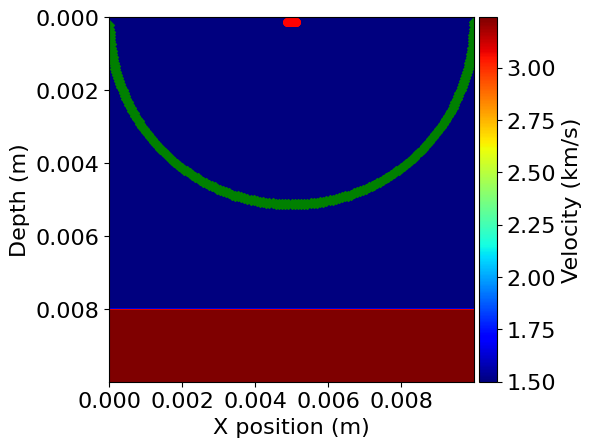

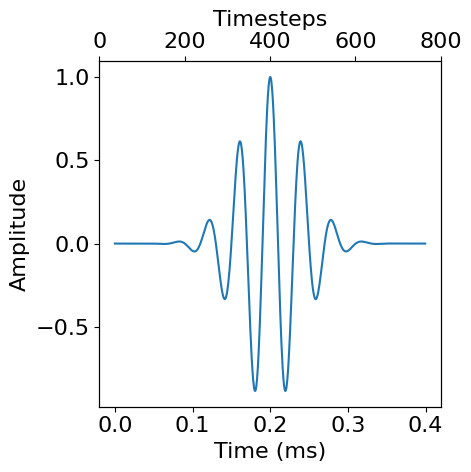

In [7]:
plot_velocity(sonars[45].model, source=sonars[45].src.coordinates.data, receiver=sonars[45].rec.coordinates.data)

plt.figure()
plt.plot(sonars[45].src.time_values[:800], sonars[45].src.signal_packet)
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
ax2 = plt.gca().twiny()
ax2.set_xlim(0, 800)
ax2.set_xlabel('Timesteps')
plt.tight_layout()
plt.show()


In [8]:
recordings = {}
for a, s in sonars.items():
    recordings[a] = run_beam(
        s.src,
        s.rec,
        s.op,
        s.u,
        s.source_distance,
        s.time_range,
        s.model.critical_dt,
        a,
        v_env,
    )

Allocating host memory for u(3, 1524, 1524) [53 MB]
Allocating host memory for rec(39816, 180) [55 MB]
nvc++-Warning-CUDA_HOME has been deprecated. Please, use NVHPC_CUDA_HOME instead.


nvc++ -g -fPIC -std=c++11 -gpu=pinned -mp -acc:gpu -fast -shared /tmp/devito-jitcache-uid543800090/ae24cf7cea07d92e3e87a2b4af40762cade94f95.cpp -lm -o /tmp/devito-jitcache-uid543800090/ae24cf7cea07d92e3e87a2b4af40762cade94f95.so


Operator `Kernel` jit-compiled `/tmp/devito-jitcache-uid543800090/ae24cf7cea07d92e3e87a2b4af40762cade94f95.cpp` in 1.44 s with `NvidiaCompiler`
Operator `Kernel` ran in 4.45 s
Global performance: [OI=1.16, 753.53 GFlops/s, 20.35 GPts/s]
Local performance:
  * section0<39814,1508,1508> ran in 3.53 s [OI=1.16, 950.77 GFlops/s, 25.70 GPts/s]
  * section1<<39814,128>,<39814,128>,<39814,128>,<39814,128>,<39814,128>> ran in 0.48 s [OI=8.44, 2.88 GFlops/s, 0.02 GPts/s]
  * section2<<39814,180>,<39814,180>,<39814,180>,<39814,180>,<39814,180>,<39814,180>> ran in 0.41 s [OI=10.75, 4.53 GFlops/s, 0.00 GPts/s]
Performance[mode=advanced] arguments: {'deviceid': -1, 'devicerm': 1}
Allocating host memory for u(3, 1524, 1524) [53 MB]
Allocating host memory for rec(39816, 180) [55 MB]


Simulation took 6.035704851150513 seconds


Operator `Kernel` fetched `/tmp/devito-jitcache-uid543800090/ae24cf7cea07d92e3e87a2b4af40762cade94f95.cpp` in 0.09 s from jit-cache
Operator `Kernel` ran in 4.36 s
Global performance: [OI=1.16, 769.09 GFlops/s, 20.77 GPts/s]
Local performance:
  * section0<39814,1508,1508> ran in 3.45 s [OI=1.16, 971.38 GFlops/s, 26.26 GPts/s]
  * section1<<39814,128>,<39814,128>,<39814,128>,<39814,128>,<39814,128>> ran in 0.48 s [OI=8.44, 2.92 GFlops/s, 0.02 GPts/s]
  * section2<<39814,180>,<39814,180>,<39814,180>,<39814,180>,<39814,180>,<39814,180>> ran in 0.41 s [OI=10.75, 4.60 GFlops/s, 0.00 GPts/s]
Performance[mode=advanced] arguments: {'deviceid': -1, 'devicerm': 1}
Allocating host memory for u(3, 1524, 1524) [53 MB]
Allocating host memory for rec(39816, 180) [55 MB]


Simulation took 4.593199968338013 seconds


Operator `Kernel` fetched `/tmp/devito-jitcache-uid543800090/ae24cf7cea07d92e3e87a2b4af40762cade94f95.cpp` in 0.09 s from jit-cache
Operator `Kernel` ran in 4.37 s
Global performance: [OI=1.16, 767.33 GFlops/s, 20.72 GPts/s]
Local performance:
  * section0<39814,1508,1508> ran in 3.46 s [OI=1.16, 969.86 GFlops/s, 26.22 GPts/s]
  * section1<<39814,128>,<39814,128>,<39814,128>,<39814,128>,<39814,128>> ran in 0.48 s [OI=8.44, 2.91 GFlops/s, 0.02 GPts/s]
  * section2<<39814,180>,<39814,180>,<39814,180>,<39814,180>,<39814,180>,<39814,180>> ran in 0.41 s [OI=10.75, 4.59 GFlops/s, 0.00 GPts/s]
Performance[mode=advanced] arguments: {'deviceid': -1, 'devicerm': 1}
Allocating host memory for u(3, 1524, 1524) [53 MB]
Allocating host memory for rec(39816, 180) [55 MB]


Simulation took 4.602373838424683 seconds


Operator `Kernel` fetched `/tmp/devito-jitcache-uid543800090/ae24cf7cea07d92e3e87a2b4af40762cade94f95.cpp` in 0.09 s from jit-cache
Operator `Kernel` ran in 4.37 s
Global performance: [OI=1.16, 767.33 GFlops/s, 20.72 GPts/s]
Local performance:
  * section0<39814,1508,1508> ran in 3.46 s [OI=1.16, 968.85 GFlops/s, 26.19 GPts/s]
  * section1<<39814,128>,<39814,128>,<39814,128>,<39814,128>,<39814,128>> ran in 0.48 s [OI=8.44, 2.91 GFlops/s, 0.02 GPts/s]
  * section2<<39814,180>,<39814,180>,<39814,180>,<39814,180>,<39814,180>,<39814,180>> ran in 0.41 s [OI=10.75, 4.58 GFlops/s, 0.00 GPts/s]
Performance[mode=advanced] arguments: {'deviceid': -1, 'devicerm': 1}
Allocating host memory for u(3, 1524, 1524) [53 MB]
Allocating host memory for rec(39816, 180) [55 MB]


Simulation took 4.603612184524536 seconds


Operator `Kernel` fetched `/tmp/devito-jitcache-uid543800090/ae24cf7cea07d92e3e87a2b4af40762cade94f95.cpp` in 0.09 s from jit-cache
Operator `Kernel` ran in 4.38 s
Global performance: [OI=1.16, 765.57 GFlops/s, 20.68 GPts/s]
Local performance:
  * section0<39814,1508,1508> ran in 3.47 s [OI=1.16, 967.57 GFlops/s, 26.16 GPts/s]
  * section1<<39814,128>,<39814,128>,<39814,128>,<39814,128>,<39814,128>> ran in 0.48 s [OI=8.44, 2.90 GFlops/s, 0.02 GPts/s]
  * section2<<39814,180>,<39814,180>,<39814,180>,<39814,180>,<39814,180>,<39814,180>> ran in 0.41 s [OI=10.75, 4.58 GFlops/s, 0.00 GPts/s]
Performance[mode=advanced] arguments: {'deviceid': -1, 'devicerm': 1}
Allocating host memory for u(3, 1524, 1524) [53 MB]
Allocating host memory for rec(39816, 180) [55 MB]


Simulation took 4.609404802322388 seconds


Operator `Kernel` fetched `/tmp/devito-jitcache-uid543800090/ae24cf7cea07d92e3e87a2b4af40762cade94f95.cpp` in 0.09 s from jit-cache
Operator `Kernel` ran in 4.38 s
Global performance: [OI=1.16, 765.57 GFlops/s, 20.68 GPts/s]
Local performance:
  * section0<39814,1508,1508> ran in 3.47 s [OI=1.16, 966.74 GFlops/s, 26.13 GPts/s]
  * section1<<39814,128>,<39814,128>,<39814,128>,<39814,128>,<39814,128>> ran in 0.48 s [OI=8.44, 2.90 GFlops/s, 0.02 GPts/s]
  * section2<<39814,180>,<39814,180>,<39814,180>,<39814,180>,<39814,180>,<39814,180>> ran in 0.41 s [OI=10.75, 4.57 GFlops/s, 0.00 GPts/s]
Performance[mode=advanced] arguments: {'deviceid': -1, 'devicerm': 1}
Allocating host memory for u(3, 1524, 1524) [53 MB]
Allocating host memory for rec(39816, 180) [55 MB]


Simulation took 4.60929799079895 seconds


Operator `Kernel` fetched `/tmp/devito-jitcache-uid543800090/ae24cf7cea07d92e3e87a2b4af40762cade94f95.cpp` in 0.09 s from jit-cache
Operator `Kernel` ran in 4.39 s
Global performance: [OI=1.16, 763.83 GFlops/s, 20.63 GPts/s]
Local performance:
  * section0<39814,1508,1508> ran in 3.47 s [OI=1.16, 965.41 GFlops/s, 26.10 GPts/s]
  * section1<<39814,128>,<39814,128>,<39814,128>,<39814,128>,<39814,128>> ran in 0.48 s [OI=8.44, 2.90 GFlops/s, 0.02 GPts/s]
  * section2<<39814,180>,<39814,180>,<39814,180>,<39814,180>,<39814,180>,<39814,180>> ran in 0.41 s [OI=10.75, 4.57 GFlops/s, 0.00 GPts/s]
Performance[mode=advanced] arguments: {'deviceid': -1, 'devicerm': 1}


Simulation took 4.627009391784668 seconds


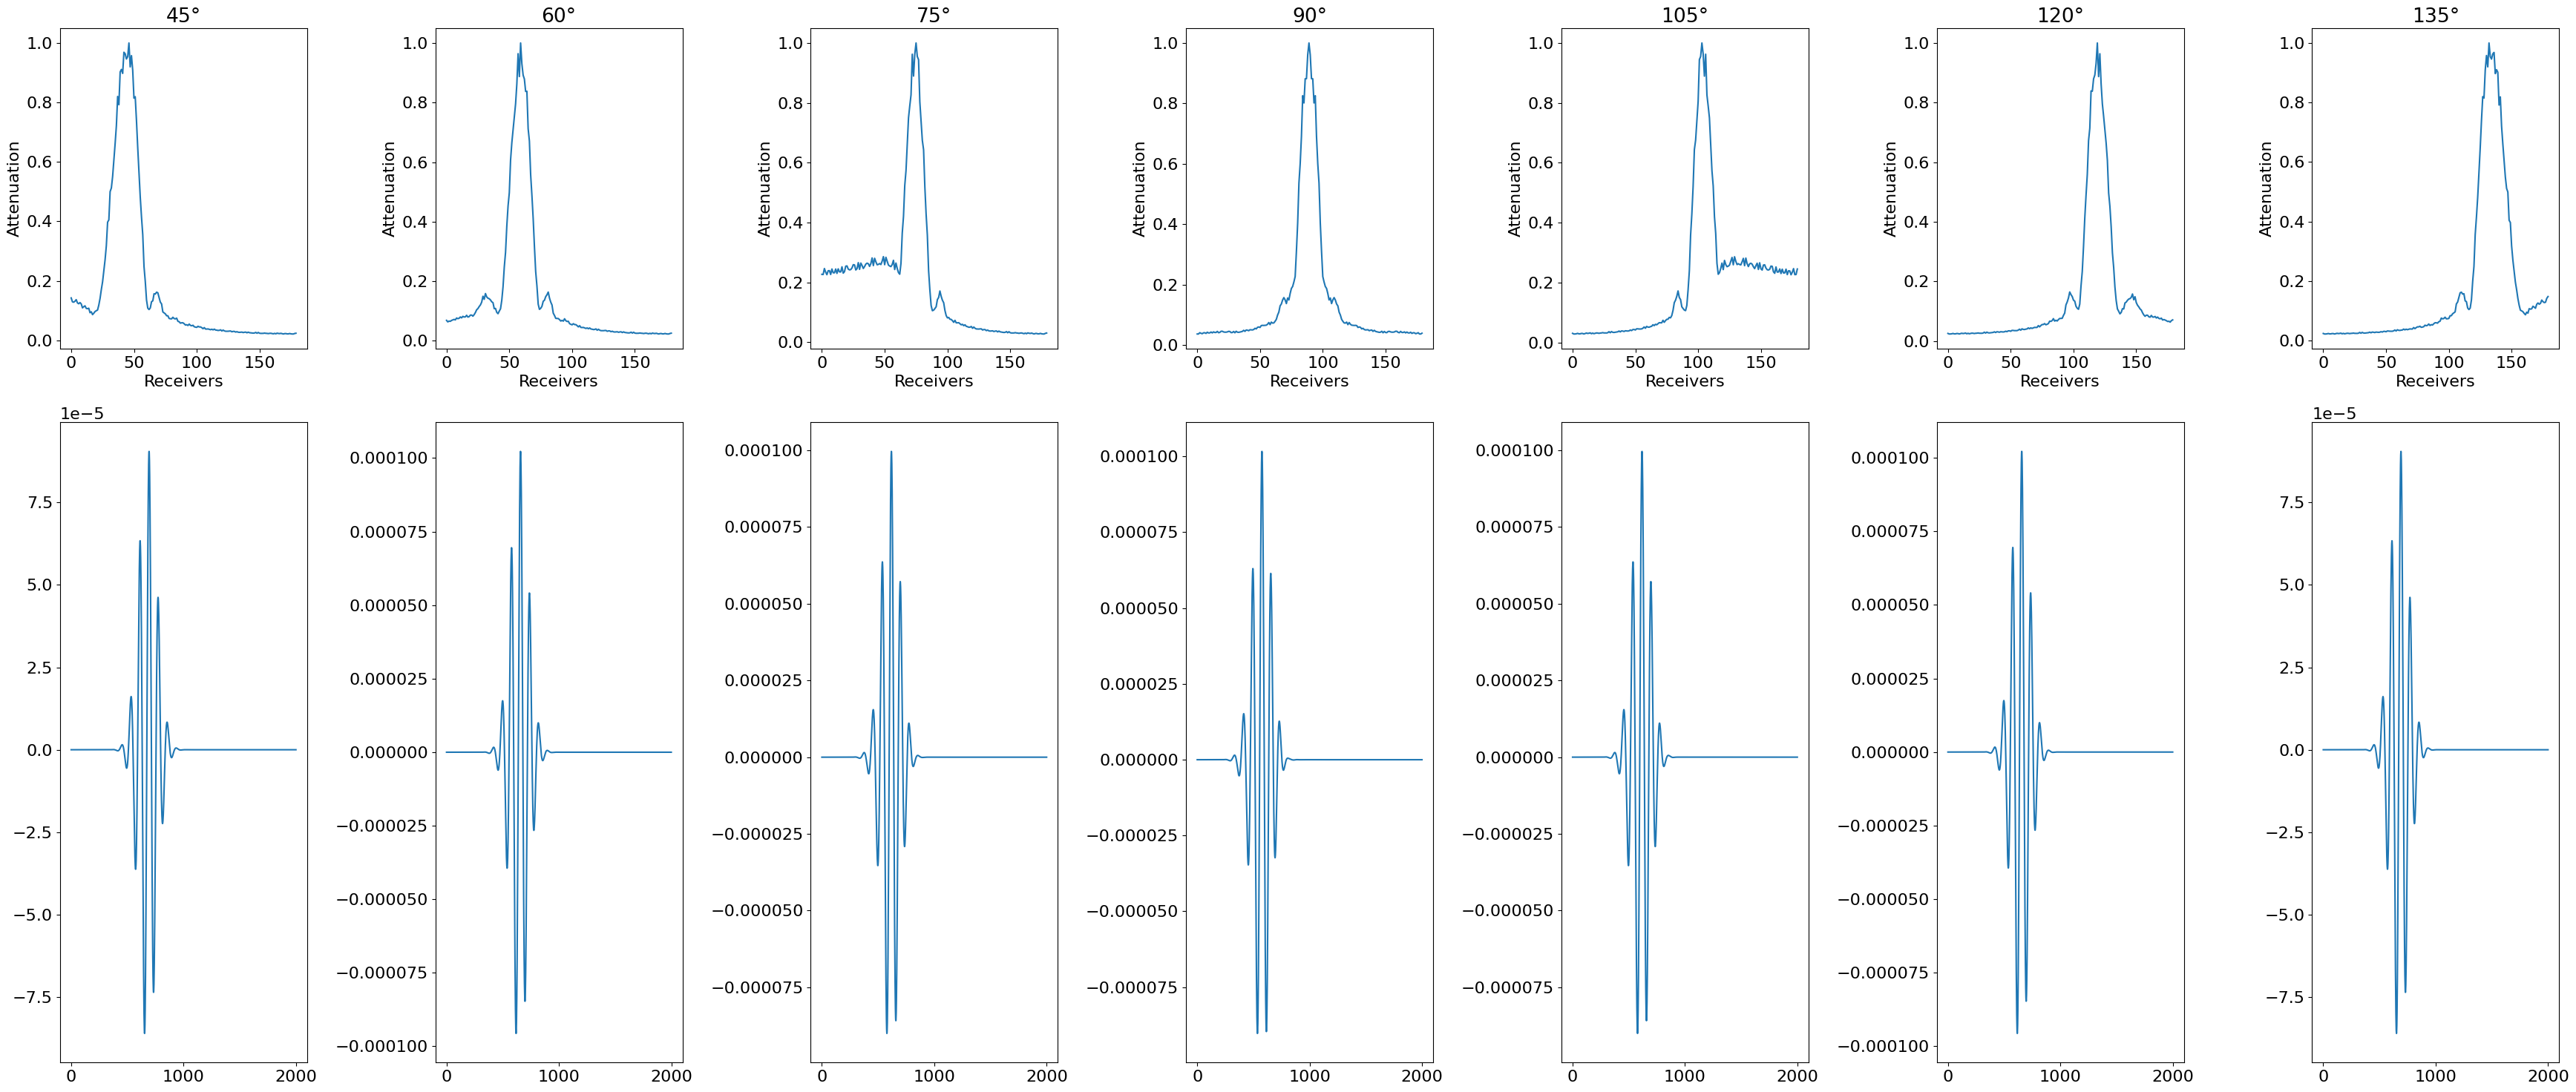

In [12]:
fig, ax = plt.subplots(2, 7, figsize=(35, 15), gridspec_kw={"height_ratios": [1, 2]})
for i, (a, r) in enumerate(recordings.items()):
    recording = np.flip(r)
    ax[0, i].plot(
        np.max(np.abs(recording[:, :]), axis=0) / np.max(np.abs(recording[:, :]))
    )
    ax[0, i].set_xlabel("Receivers")
    ax[0, i].set_ylabel("Attenuation")
    ax[0, i].set_title(f"{a}°")
    ax[0, i].tick_params()
    
    ax[1, i].plot(r[6500:8500, 180 - a])
fig.tight_layout()

### Ideal signal

In [13]:
domain_size = (20, 20)
distances = [0.25, 0.5, 0.75]
f0 = 50
space_order = 8
spatial_dist = round(v_env / f0 / 3, 3)
dt = spatial_dist / 20
source_distance = 0.002
v_env = 1.5

In [14]:
ideal_signals_90 = {}
snaps = {}
for d in distances:
    ideal_signals_90[d] = get_ideal_signal(
        domain_size,
        f0,
        v_env,
        source_distance,
        ns,
        d,
        90,
        dt,
        spatial_dist,
        space_order,
        plot=False,
    )

Operator `initdamp` generated in 0.35 s
  * lowering.Clusters: 0.16 s (46.1 %)
     * specializing.Clusters: 0.10 s (28.9 %)
  * lowering.IET: 0.14 s (40.4 %)
     * specializing.IET: 0.11 s (31.7 %)
Flops reduction after symbolic optimization: [72 --> 72]
Operator `initdamp` fetched `/tmp/devito-jitcache-uid543800090/67213697f431dcabdbe9ec83ea71a4399a1b9618.cpp` in 0.07 s from jit-cache
Operator `initdamp` ran in 0.02 s
Global performance: [OI=0.31, 1.41 GFlops/s]
Local performance:
  * section0<> ran in 0.01 s 
  * section1<254> ran in 0.01 s [OI=0.88, 0.15 GFlops/s, 0.00 GPts/s]
  * section2<254,2508> ran in 0.01 s [OI=0.69, 250.27 GFlops/s, 0.00 GPts/s]
  * section3<254> ran in 0.01 s [OI=0.88, 0.17 GFlops/s, 0.00 GPts/s]
  * section4<254,2508> ran in 0.01 s [OI=0.69, 318.52 GFlops/s, 0.00 GPts/s]
  * section5<254> ran in 0.01 s [OI=0.88, 0.17 GFlops/s, 0.00 GPts/s]
  * section6<2508,254> ran in 0.01 s [OI=0.69, 304.67 GFlops/s, 0.00 GPts/s]
  * section7<254> ran in 0.01 s [OI=0.88

Simulation took 6.955742597579956 seconds


Operator `initdamp` generated in 0.36 s
  * lowering.Clusters: 0.17 s (47.4 %)
     * specializing.Clusters: 0.11 s (30.7 %)
  * lowering.IET: 0.15 s (41.8 %)
     * specializing.IET: 0.11 s (30.7 %)
Flops reduction after symbolic optimization: [72 --> 72]
Operator `initdamp` fetched `/tmp/devito-jitcache-uid543800090/67213697f431dcabdbe9ec83ea71a4399a1b9618.cpp` in 0.06 s from jit-cache
Operator `initdamp` ran in 0.01 s
Global performance: [OI=0.31, 2.81 GFlops/s]
Local performance:
  * section0<> ran in 0.01 s 
  * section1<254> ran in 0.01 s [OI=0.88, 0.18 GFlops/s, 0.00 GPts/s]
  * section2<254,2508> ran in 0.01 s [OI=0.69, 350.37 GFlops/s, 0.00 GPts/s]
  * section3<254> ran in 0.01 s [OI=0.88, 0.23 GFlops/s, 0.00 GPts/s]
  * section4<254,2508> ran in 0.01 s [OI=0.69, 467.16 GFlops/s, 0.00 GPts/s]
  * section5<254> ran in 0.01 s [OI=0.88, 0.23 GFlops/s, 0.00 GPts/s]
  * section6<2508,254> ran in 0.01 s [OI=0.69, 437.96 GFlops/s, 0.00 GPts/s]
  * section7<254> ran in 0.01 s [OI=0.88

Simulation took 7.0025529861450195 seconds


Operator `initdamp` generated in 0.36 s
  * lowering.Clusters: 0.17 s (47.7 %)
     * specializing.Clusters: 0.11 s (30.9 %)
  * lowering.IET: 0.14 s (39.3 %)
     * specializing.IET: 0.11 s (30.9 %)
Flops reduction after symbolic optimization: [72 --> 72]
Operator `initdamp` fetched `/tmp/devito-jitcache-uid543800090/67213697f431dcabdbe9ec83ea71a4399a1b9618.cpp` in 0.06 s from jit-cache
Operator `initdamp` ran in 0.02 s
Global performance: [OI=0.31, 1.41 GFlops/s]
Local performance:
  * section0<> ran in 0.01 s 
  * section1<254> ran in 0.01 s [OI=0.88, 0.20 GFlops/s, 0.00 GPts/s]
  * section2<254,2508> ran in 0.01 s [OI=0.69, 333.69 GFlops/s, 0.00 GPts/s]
  * section3<254> ran in 0.01 s [OI=0.88, 0.20 GFlops/s, 0.00 GPts/s]
  * section4<254,2508> ran in 0.01 s [OI=0.69, 500.53 GFlops/s, 0.00 GPts/s]
  * section5<254> ran in 0.01 s [OI=0.88, 0.23 GFlops/s, 0.00 GPts/s]
  * section6<2508,254> ran in 0.01 s [OI=0.69, 467.16 GFlops/s, 0.00 GPts/s]
  * section7<254> ran in 0.01 s [OI=0.88

Simulation took 6.991714954376221 seconds


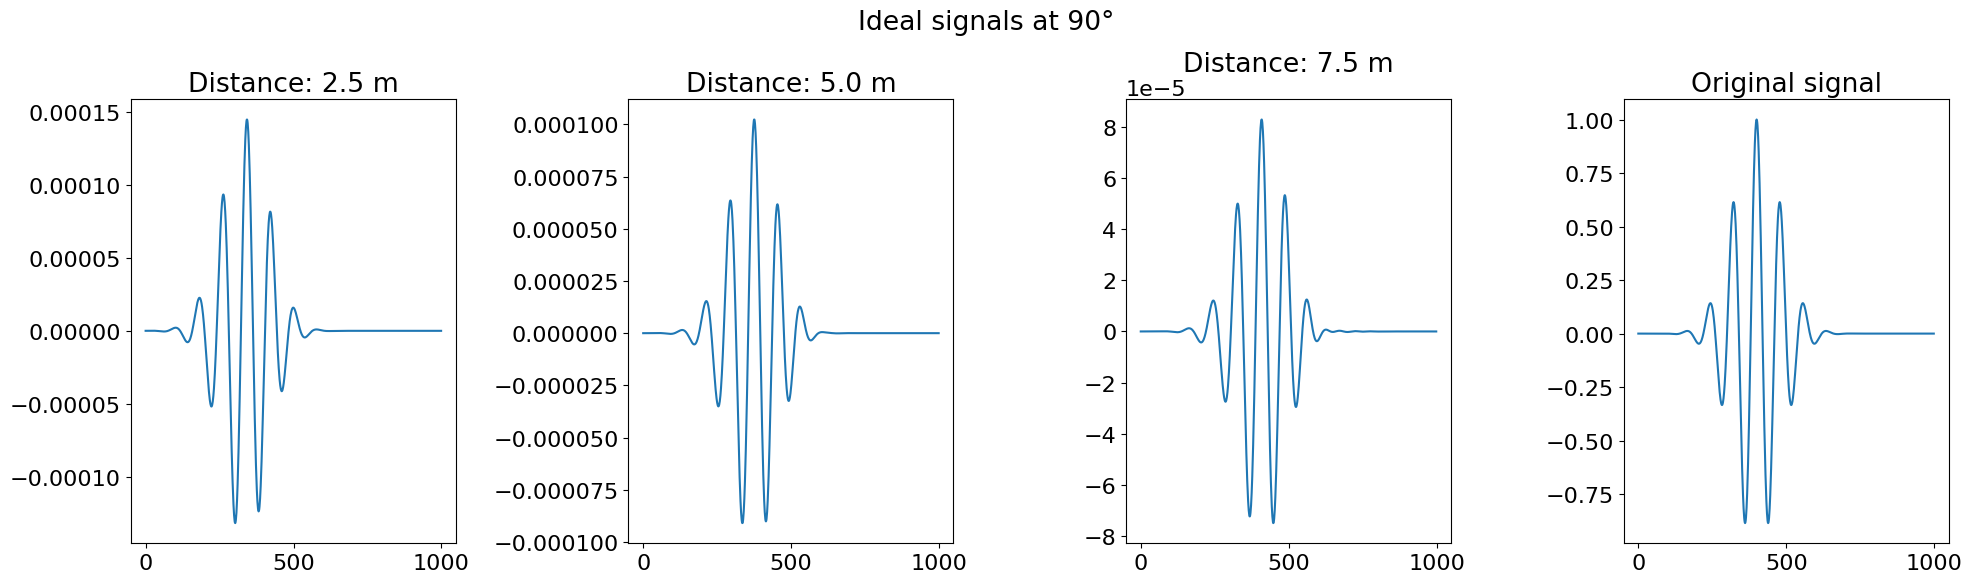

In [15]:
fig, ax = plt.subplots(1, 4, figsize=(20, 6))
fig.suptitle("Ideal signals at 90°")
ax[0].plot(ideal_signals_90[.25][3400:4400])
ax[0].set_title(f'Distance: {distances[0] * 20 / 2} m')
ax[1].plot(ideal_signals_90[.5][6700:7700])
ax[1].set_title(f'Distance: {distances[1] * 20 / 2} m')
ax[2].plot(ideal_signals_90[.75][10000:11000])
ax[2].set_title(f'Distance: {distances[2] * 20 / 2} m')
ax[3].plot(src.data[:1000,0])
ax[3].set_title(f'Original signal')
fig.tight_layout()
plt.savefig("ideal_signals_90.pdf", bbox_inches="tight", dpi=600, format="pdf")

In [16]:
ideal_signals_45 = {}
for d in distances:
    ideal_signals_45[d] = get_ideal_signal(
        domain_size,
        f0,
        v_env,
        source_distance,
        ns,
        d,
        45,
        dt,
        spatial_dist,
        space_order,
        plot=False,
    )

Operator `initdamp` generated in 0.36 s
  * lowering.Clusters: 0.16 s (45.4 %)
     * specializing.Clusters: 0.11 s (31.3 %)
  * lowering.IET: 0.14 s (39.8 %)
     * specializing.IET: 0.11 s (31.3 %)
Flops reduction after symbolic optimization: [72 --> 72]
Operator `initdamp` fetched `/tmp/devito-jitcache-uid543800090/67213697f431dcabdbe9ec83ea71a4399a1b9618.cpp` in 0.06 s from jit-cache
Operator `initdamp` ran in 0.02 s
Global performance: [OI=0.31, 1.41 GFlops/s]
Local performance:
  * section0<> ran in 0.01 s 
  * section1<254> ran in 0.01 s [OI=0.88, 0.15 GFlops/s, 0.00 GPts/s]
  * section2<254,2508> ran in 0.01 s [OI=0.69, 259.54 GFlops/s, 0.00 GPts/s]
  * section3<254> ran in 0.01 s [OI=0.88, 0.17 GFlops/s, 0.00 GPts/s]
  * section4<254,2508> ran in 0.01 s [OI=0.69, 318.52 GFlops/s, 0.00 GPts/s]
  * section5<254> ran in 0.01 s [OI=0.88, 0.17 GFlops/s, 0.00 GPts/s]
  * section6<2508,254> ran in 0.01 s [OI=0.69, 304.67 GFlops/s, 0.00 GPts/s]
  * section7<254> ran in 0.01 s [OI=0.88

Simulation took 6.997083425521851 seconds


Operator `initdamp` generated in 0.36 s
  * lowering.Clusters: 0.17 s (47.5 %)
     * specializing.Clusters: 0.11 s (30.7 %)
  * lowering.IET: 0.14 s (39.1 %)
     * specializing.IET: 0.11 s (30.7 %)
Flops reduction after symbolic optimization: [72 --> 72]
Operator `initdamp` fetched `/tmp/devito-jitcache-uid543800090/67213697f431dcabdbe9ec83ea71a4399a1b9618.cpp` in 0.06 s from jit-cache
Operator `initdamp` ran in 0.02 s
Global performance: [OI=0.31, 1.41 GFlops/s]
Local performance:
  * section0<> ran in 0.01 s 
  * section1<254> ran in 0.01 s [OI=0.88, 0.23 GFlops/s, 0.00 GPts/s]
  * section2<254,2508> ran in 0.01 s [OI=0.69, 350.37 GFlops/s, 0.00 GPts/s]
  * section3<254> ran in 0.01 s [OI=0.88, 0.20 GFlops/s, 0.00 GPts/s]
  * section4<254,2508> ran in 0.01 s [OI=0.69, 500.53 GFlops/s, 0.00 GPts/s]
  * section5<254> ran in 0.01 s [OI=0.88, 0.23 GFlops/s, 0.00 GPts/s]
  * section6<2508,254> ran in 0.01 s [OI=0.69, 437.96 GFlops/s, 0.00 GPts/s]
  * section7<254> ran in 0.01 s [OI=0.88

Simulation took 7.034823656082153 seconds


Operator `initdamp` generated in 0.37 s
  * lowering.Clusters: 0.17 s (47.0 %)
     * specializing.Clusters: 0.11 s (30.5 %)
  * lowering.IET: 0.15 s (41.5 %)
     * specializing.IET: 0.11 s (30.5 %)
Flops reduction after symbolic optimization: [72 --> 72]
Operator `initdamp` fetched `/tmp/devito-jitcache-uid543800090/67213697f431dcabdbe9ec83ea71a4399a1b9618.cpp` in 0.06 s from jit-cache
Operator `initdamp` ran in 0.02 s
Global performance: [OI=0.31, 1.41 GFlops/s]
Local performance:
  * section0<> ran in 0.01 s 
  * section1<254> ran in 0.01 s [OI=0.88, 0.20 GFlops/s, 0.00 GPts/s]
  * section2<254,2508> ran in 0.01 s [OI=0.69, 350.37 GFlops/s, 0.00 GPts/s]
  * section3<254> ran in 0.01 s [OI=0.88, 0.20 GFlops/s, 0.00 GPts/s]
  * section4<254,2508> ran in 0.01 s [OI=0.69, 467.16 GFlops/s, 0.00 GPts/s]
  * section5<254> ran in 0.01 s [OI=0.88, 0.23 GFlops/s, 0.00 GPts/s]
  * section6<2508,254> ran in 0.01 s [OI=0.69, 437.96 GFlops/s, 0.00 GPts/s]
  * section7<254> ran in 0.01 s [OI=0.88

Simulation took 7.0492424964904785 seconds


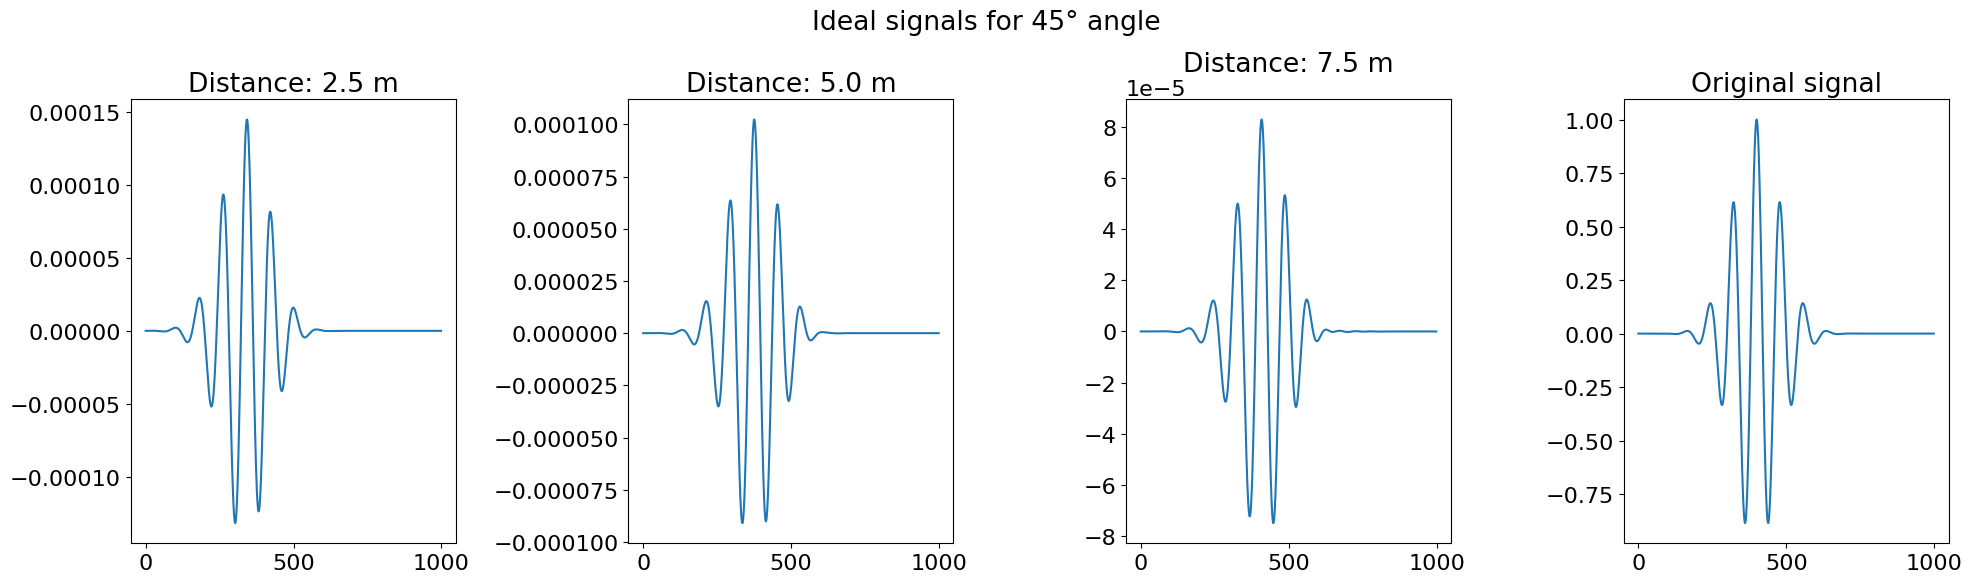

In [17]:
fig, ax = plt.subplots(1, 4, figsize=(20, 6))
fig.suptitle('Ideal signals for 45° angle')
ax[0].plot(ideal_signals_90[.25][3400:4400])
ax[0].set_title(f'Distance: {distances[0] * 20 / 2} m')
ax[1].plot(ideal_signals_90[.5][6700:7700])
ax[1].set_title(f'Distance: {distances[1] * 20 / 2} m')
ax[2].plot(ideal_signals_90[.75][10000:11000])
ax[2].set_title(f'Distance: {distances[2] * 20 / 2} m')
ax[3].plot(src.data[:1000,0])
ax[3].set_title(f'Original signal')
fig.tight_layout()
# save the figure as pdf
plt.savefig("ideal_signals_45.pdf", bbox_inches="tight", dpi=600, format="pdf")

### Detection with correlation

In [18]:
domain_size = (60, 30)
radius = 28
v_env = 1.5
ns = 128
source_distance = 0.002
cy = (ns - 1) / 2 * source_distance + source_distance
f0 = 50
space_order = 8
spatial_dist = round(v_env / f0 / 3, 3)
dt = spatial_dist / 20

In [19]:
sonar = Sonar(domain_size, f0, v_env, EllipsisBottom(True), space_order=space_order, dt=dt, spatial_dist=spatial_dist)
sonar.set_source()
sonar.finalize()

51it [00:05,  9.19it/s]
Operator `initdamp` generated in 0.37 s
  * lowering.Clusters: 0.17 s (46.9 %)
     * specializing.Clusters: 0.11 s (30.4 %)
  * lowering.IET: 0.15 s (41.4 %)
     * specializing.IET: 0.11 s (30.4 %)
Flops reduction after symbolic optimization: [72 --> 72]
Operator `initdamp` fetched `/tmp/devito-jitcache-uid543800090/67213697f431dcabdbe9ec83ea71a4399a1b9618.cpp` in 0.06 s from jit-cache
Operator `initdamp` ran in 0.04 s
Global performance: [OI=0.22, 1.40 GFlops/s]
Local performance:
  * section0<> ran in 0.01 s 
  * section1<254> ran in 0.01 s [OI=0.88, 0.14 GFlops/s, 0.00 GPts/s]
  * section2<254,3508> ran in 0.01 s [OI=0.69, 288.28 GFlops/s, 0.00 GPts/s]
  * section3<254> ran in 0.01 s [OI=0.88, 0.17 GFlops/s, 0.00 GPts/s]
  * section4<254,3508> ran in 0.01 s [OI=0.69, 326.72 GFlops/s, 0.00 GPts/s]
  * section5<254> ran in 0.01 s [OI=0.88, 0.15 GFlops/s, 0.00 GPts/s]
  * section6<6508,254> ran in 0.01 s [OI=0.69, 443.50 GFlops/s, 0.00 GPts/s]
  * section7<254

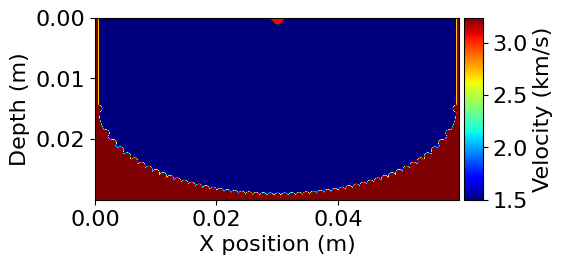

In [20]:
plot_velocity(sonar.model, source=sonar.src.coordinates.data, receiver=sonar.rec.coordinates.data)

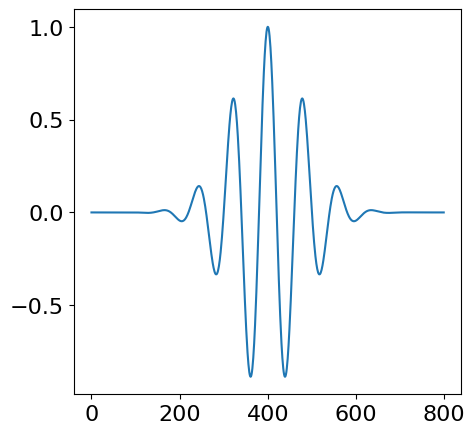

In [21]:
ideal_signal = sonar.src.signal_packet
plt.plot(ideal_signal)
plt.show()

In [22]:
recording_45 = run_beam(
        sonar.src,
        sonar.rec,
        sonar.op,
        sonar.u,
        sonar.source_distance,
        sonar.time_range,
        sonar.model.critical_dt,
        45,
        v_env,
    )

Allocating host memory for u(3, 6524, 3524) [526 MB]
Allocating host memory for rec(123139, 128) [120 MB]


nvc++ -g -fPIC -std=c++11 -gpu=pinned -mp -acc:gpu -fast -shared /tmp/devito-jitcache-uid543800090/144ad251e5ee0ab426a694bae5bf7af16743bfd8.cpp -lm -o /tmp/devito-jitcache-uid543800090/144ad251e5ee0ab426a694bae5bf7af16743bfd8.so


nvc++-Warning-CUDA_HOME has been deprecated. Please, use NVHPC_CUDA_HOME instead.
Operator `Kernel` jit-compiled `/tmp/devito-jitcache-uid543800090/144ad251e5ee0ab426a694bae5bf7af16743bfd8.cpp` in 0.99 s with `NvidiaCompiler`
Operator `Kernel` ran in 102.41 s
Global performance: [OI=1.28, 1125.56 GFlops/s, 27.46 GPts/s]
Local performance:
  * section0<123137,6508,3508> ran in 99.46 s [OI=1.28, 1158.90 GFlops/s, 28.27 GPts/s]
  * section1<<123137,128>,<123137,128>,<123137,128>,<123137,128>,<123137,128>> ran in 1.50 s [OI=8.44, 2.85 GFlops/s, 0.02 GPts/s]
  * section2<<123137,128>,<123137,128>,<123137,128>,<123137,128>,<123137,128>,<123137,128>> ran in 1.29 s [OI=10.75, 3.16 GFlops/s, 0.00 GPts/s]
Performance[mode=advanced] arguments: {'deviceid': -1, 'devicerm': 1}


Simulation took 103.82516813278198 seconds


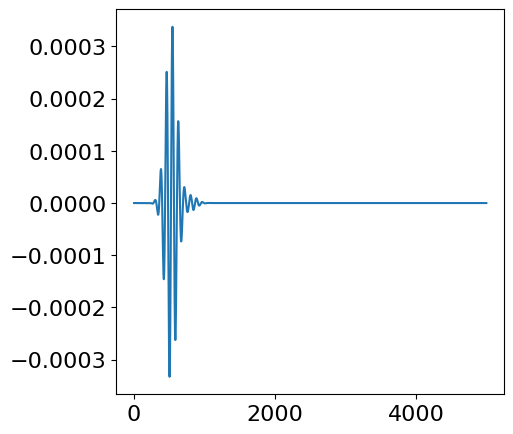

In [23]:
plt.plot(recording_45[:5000, 64])
start_time = np.argmax(recording_45[:5000, 64])

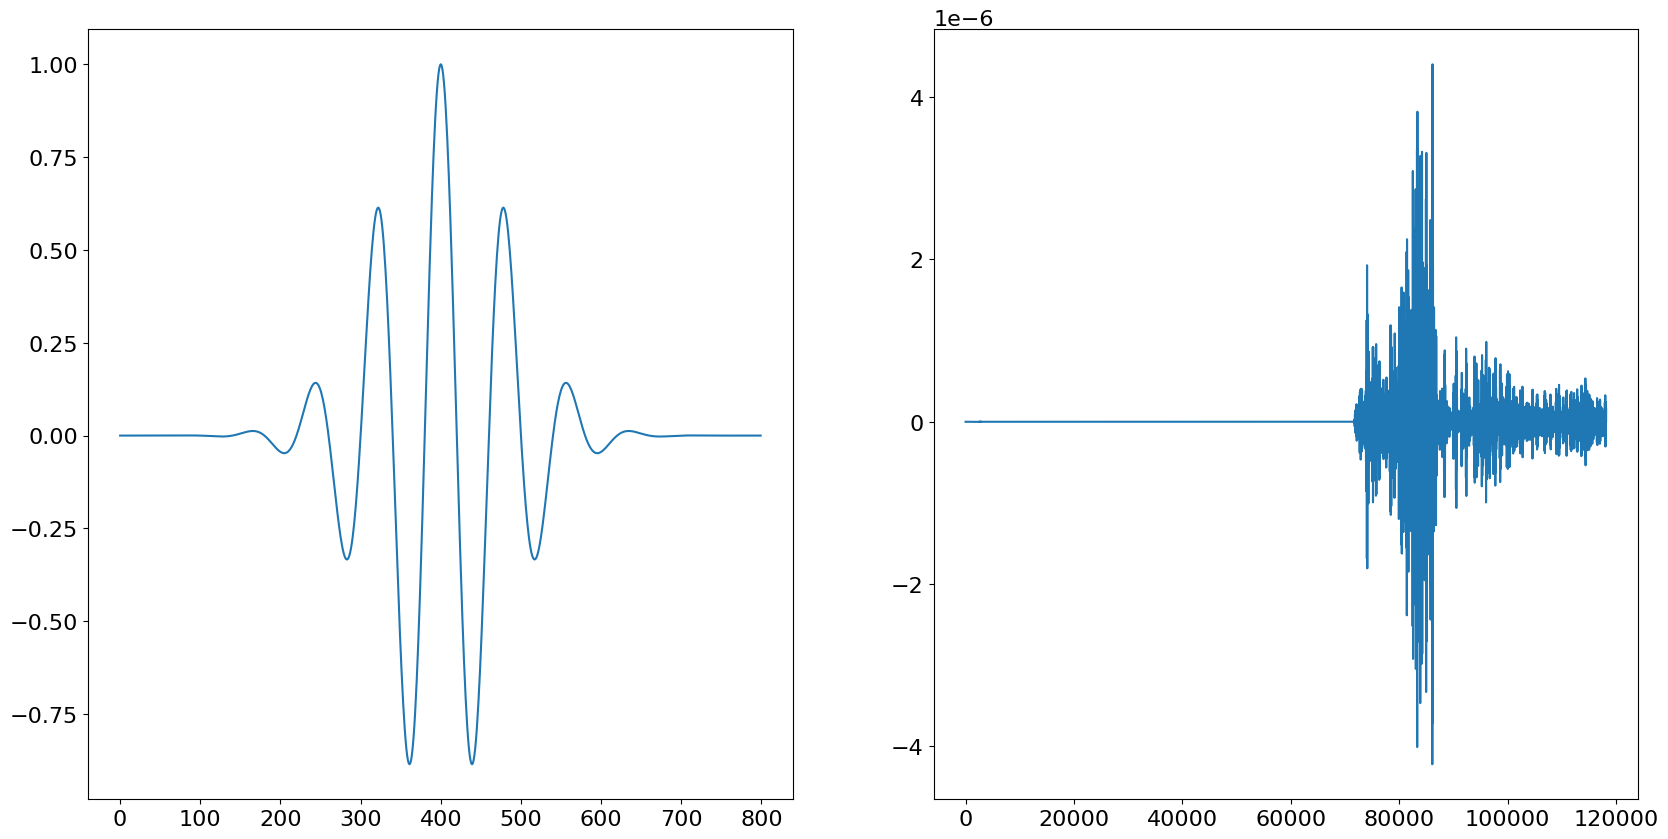

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].plot(ideal_signal)
ax[1].plot(recording_45[5000:, 64])

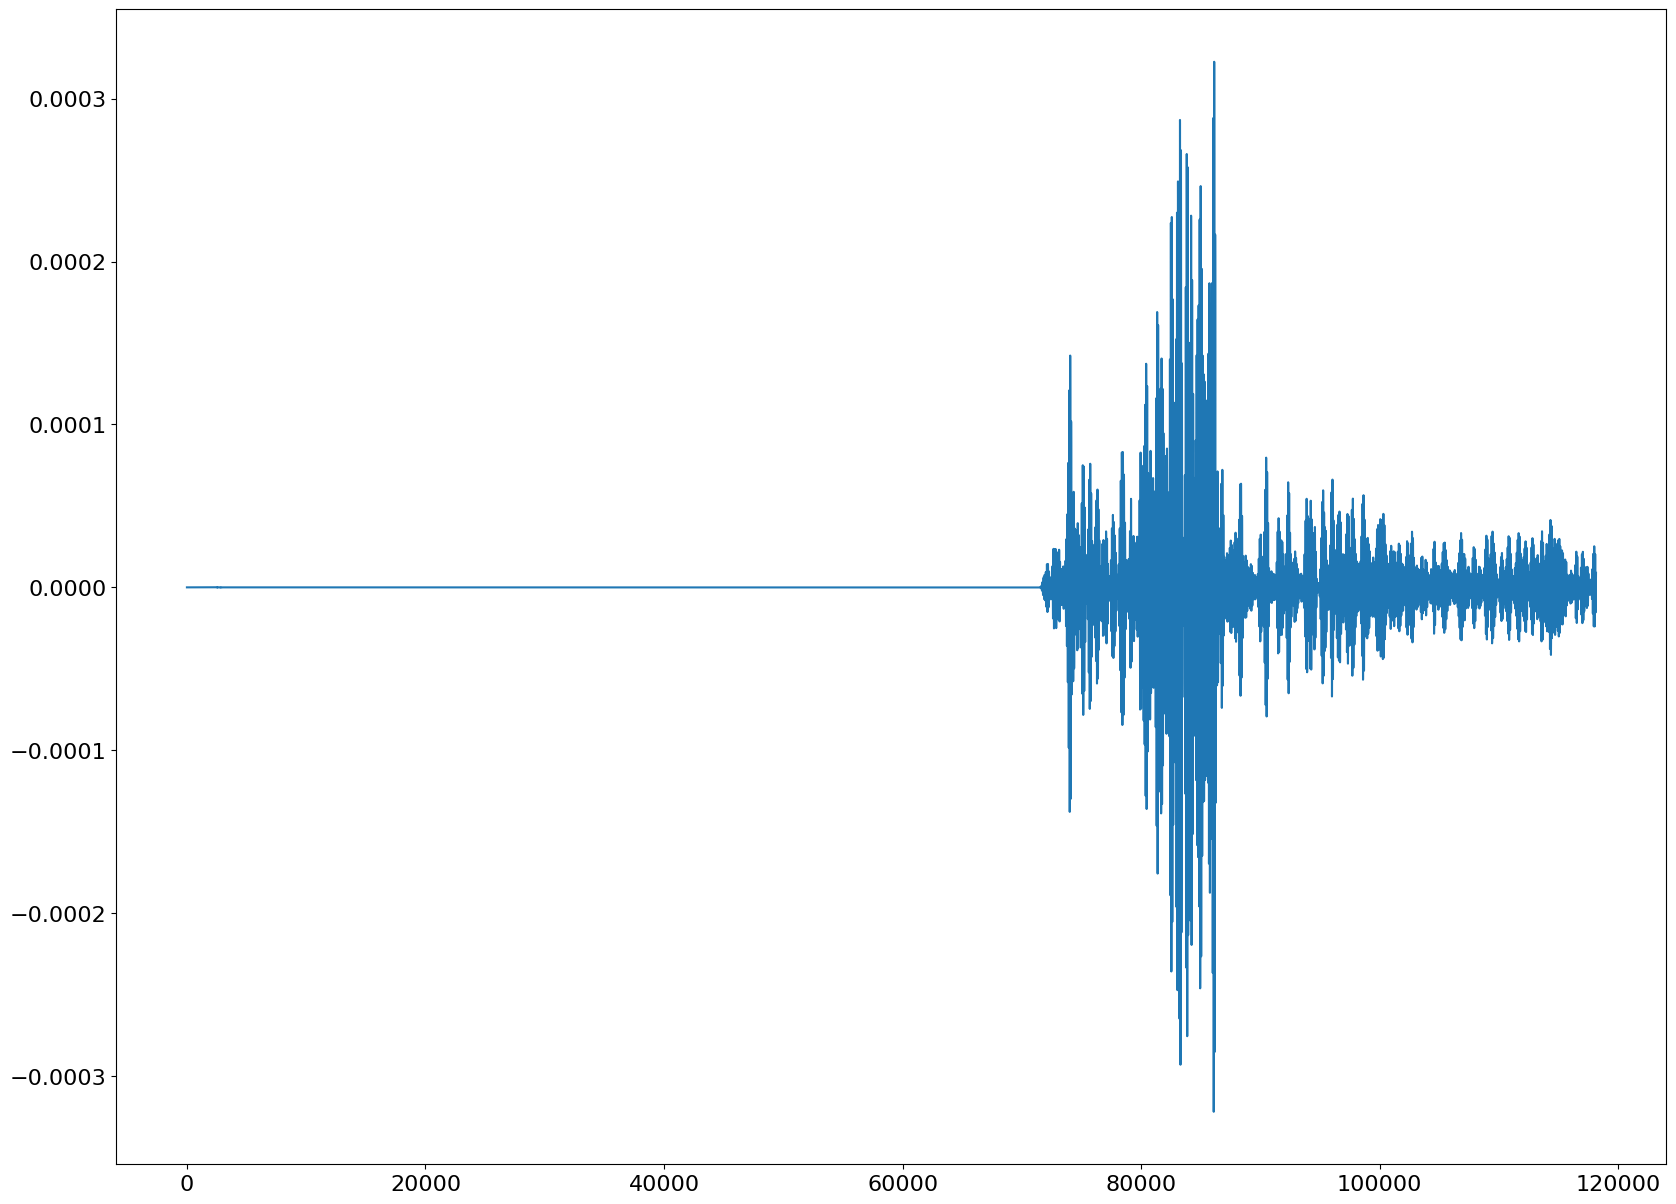

86127


In [25]:
correlate = np.correlate(recording_45[5000:, 64], ideal_signal, mode='same')
plt.figure(figsize=(20, 15))
plt.plot(correlate)
plt.show()
print(np.argmax(correlate))

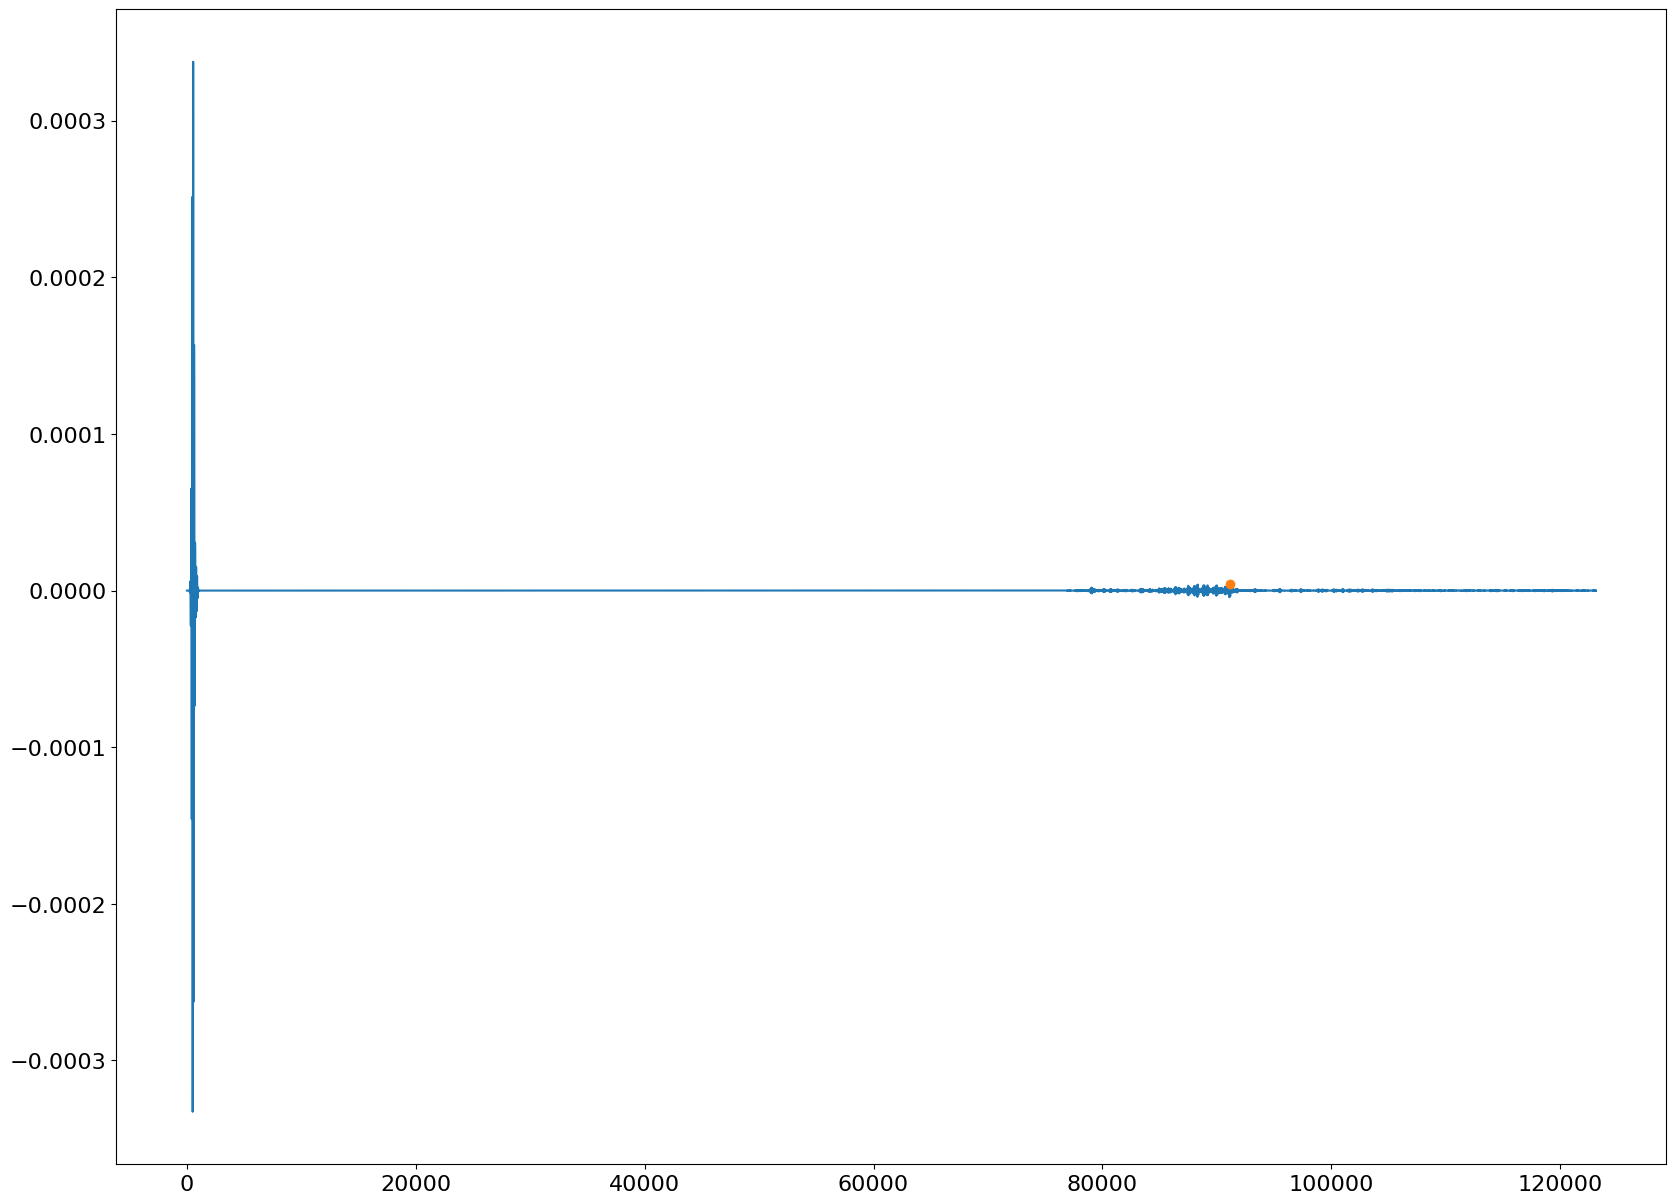

In [26]:
peak = 5000 + correlate.argmax()
## change the figure size
plt.figure(figsize=(20, 15))
plt.plot(recording_45[:, 64])
plt.plot(peak, recording_45[peak, 64], 'o')
plt.show()

In [27]:
print(f"Distance: {(peak - start_time) * sonar.model.critical_dt * v_env / 2} m")

Distance: 33.968625 m


### f0 ~ dx ~ dt

In [20]:
domain_size = (20, 20)
v_env = 1.5
ns = 128
source_distance = 0.002
f0 = 50
angle = 90

In [31]:
spatial_dist = round(v_env / f0 / 3, 3)
dt = spatial_dist / 10
print(f"spatial_dist: {spatial_dist}")
print(f"dt: {dt}")
print(f"{1 / dt}")

spatial_dist: 0.01
dt: 0.001
1000.0


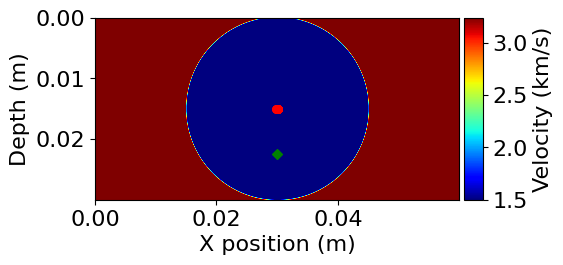

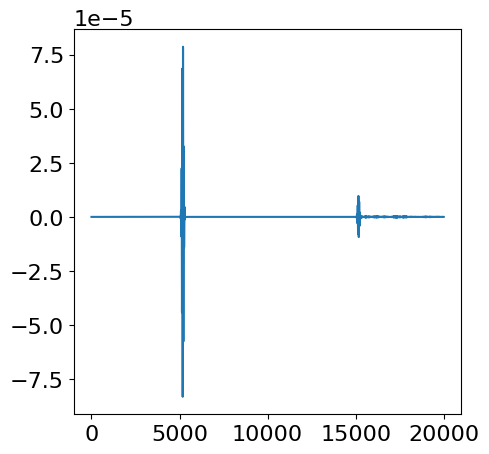

In [32]:
recording = get_ideal_signal(domain_size, f0, v_env, source_distance, ns, 0.5, 90, dt, spatial_dist, space_order = 16, plot=True)

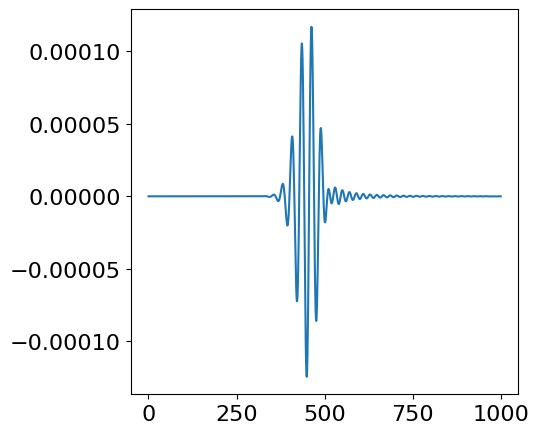

In [30]:
plt.plot(recording[3000:4000])

### Snapshot

In [34]:
domain_size = (60, 30)
v_env = 1.5
source_distance = 0.002
ns = 128
cy = (ns - 1) / 2 * source_distance + source_distance
f0 = 5
space_order = 8
spatial_dist = round(v_env / f0 / 3, 3)
dt = spatial_dist / 20

In [35]:
sonar = Sonar(domain_size, f0, v_env, EllipsisBottom(True), source_distance=source_distance, ns=ns, space_order=space_order, dt=dt, spatial_dist=spatial_dist)
sonar.set_source()
sonar.finalize(snapshot_delay=0.1)

51it [00:00, 5230.83it/s]
Operator `initdamp` generated in 0.35 s
  * lowering.Clusters: 0.16 s (46.1 %)
     * specializing.Clusters: 0.10 s (28.9 %)
  * lowering.IET: 0.14 s (40.4 %)
     * specializing.IET: 0.11 s (31.7 %)
Flops reduction after symbolic optimization: [72 --> 72]
nvc++-Warning-CUDA_HOME has been deprecated. Please, use NVHPC_CUDA_HOME instead.


nvc++ -g -fPIC -std=c++11 -gpu=pinned -mp -acc:gpu -fast -shared /tmp/devito-jitcache-uid543800090/e9e25937125eaad53e566e64dc7da769a5a27f54.cpp -lm -o /tmp/devito-jitcache-uid543800090/e9e25937125eaad53e566e64dc7da769a5a27f54.so


Operator `initdamp` jit-compiled `/tmp/devito-jitcache-uid543800090/e9e25937125eaad53e566e64dc7da769a5a27f54.cpp` in 0.81 s with `NvidiaCompiler`
Operator `initdamp` ran in 0.01 s
Global performance: [OI=0.22, 0.06 GFlops/s]
Local performance:
  * section0<> ran in 0.01 s 
  * section1<25> ran in 0.01 s [OI=0.88, 0.02 GFlops/s, 0.00 GPts/s]
  * section2<25,350> ran in 0.01 s [OI=0.69, 6.88 GFlops/s, 0.00 GPts/s]
  * section3<25> ran in 0.01 s [OI=0.88, 0.02 GFlops/s, 0.00 GPts/s]
  * section4<25,350> ran in 0.01 s [OI=0.69, 6.88 GFlops/s, 0.00 GPts/s]
  * section5<25> ran in 0.01 s [OI=0.88, 0.02 GFlops/s, 0.00 GPts/s]
  * section6<650,25> ran in 0.01 s [OI=0.69, 12.77 GFlops/s, 0.00 GPts/s]
  * section7<25> ran in 0.01 s [OI=0.88, 0.02 GFlops/s, 0.00 GPts/s]
  * section8<650,25> ran in 0.01 s [OI=0.69, 12.77 GFlops/s, 0.00 GPts/s]
Performance[mode=advanced] arguments: {'deviceid': -1, 'devicerm': 1}
Allocating host memory for vp(666, 366) [2 MB]
nvc++-Warning-CUDA_HOME has been deprec

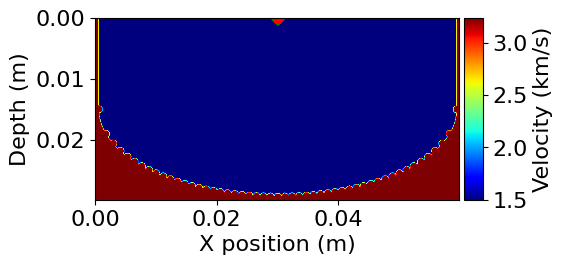

In [36]:
plot_velocity(sonar.model, source=sonar.src.coordinates.data, receiver=sonar.rec.coordinates.data)

In [37]:
recording = run_beam(
                    sonar.src,
                    sonar.rec,
                    sonar.op,
                    sonar.u,
                    source_distance,
                    sonar.time_range,
                    sonar.model.critical_dt,
                    45,
                    v_env,
                )

Allocating host memory for u(3, 666, 366) [6 MB]
Allocating host memory for rec(12315, 128) [12 MB]
Allocating host memory for usave(616, 666, 366) [1 GB]


nvc++ -g -fPIC -std=c++11 -gpu=pinned -mp -acc:gpu -fast -shared /tmp/devito-jitcache-uid543800090/7bdbad0a8a1cab6c50576c107302d9d7bbd2c26f.cpp -lm -o /tmp/devito-jitcache-uid543800090/7bdbad0a8a1cab6c50576c107302d9d7bbd2c26f.so


nvc++-Warning-CUDA_HOME has been deprecated. Please, use NVHPC_CUDA_HOME instead.
Operator `Kernel` jit-compiled `/tmp/devito-jitcache-uid543800090/7bdbad0a8a1cab6c50576c107302d9d7bbd2c26f.cpp` in 0.96 s with `NvidiaCompiler`
Operator `Kernel` ran in 0.70 s
Global performance: [OI=0.85, 165.26 GFlops/s, 4.01 GPts/s]
Local performance:
  * section0<12313,650,350> ran in 0.23 s [OI=1.26, 510.13 GFlops/s, 12.45 GPts/s]
  * section1<> ran in 0.01 s 
  * section2<<12313,128>,<12313,128>,<12313,128>,<12313,128>,<12313,128>> ran in 0.14 s [OI=8.44, 3.18 GFlops/s, 0.02 GPts/s]
  * section3<<12313,128>,<12313,128>,<12313,128>,<12313,128>,<12313,128>,<12313,128>> ran in 0.12 s [OI=10.75, 3.40 GFlops/s, 0.00 GPts/s]
Performance[mode=advanced] arguments: {'deviceid': -1, 'devicerm': 1}


Simulation took 2.6447975635528564 seconds


In [39]:
plot_snapshot_and_signal(sonar.usave.data, recording[:, 64], sonar.model, f"signal_boundary.gif", sonar.src.coordinates.data, sonar.rec.coordinates.data)

MovieWriter ffmpeg unavailable; using Pillow instead.
